In [1]:
import pandas as pd
from prophet import Prophet

train_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\train_data.csv")
test_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\test_data.csv")

prophet_train = train_df[["date", "solar_radiation_langley"]].copy()
prophet_train.columns = ["ds", "y"]

model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_train)

# For training data
train_future = prophet_train[["ds"]]
train_forecast = model.predict(train_future)

train_df["trend"] = train_forecast["trend"].values
train_df["seasonal"] = train_forecast["yearly"].values + train_forecast["daily"].values
train_df["residual"] = train_df["solar_radiation_langley"] - train_df["trend"] - train_df["seasonal"]

# For testing data
prophet_test = test_df[["date"]].copy()
prophet_test.columns = ["ds"]
test_forecast = model.predict(prophet_test)

test_df["trend"] = test_forecast["trend"].values
test_df["seasonal"] = test_forecast["yearly"].values + test_forecast["daily"].values
test_df["residual"] = test_df["solar_radiation_langley"] - test_df["trend"] - test_df["seasonal"]


input_features = [
    "trend", "seasonal", "sin_day", "cos_day",
    "mean_temp_celsius", "vapor_pressure_pa", "precipitation_mm",
    "snow_water_equivalent_mm", "temp_range"
]

X_train = train_df[input_features].values
y_train = train_df["solar_radiation_langley"].values

X_test = test_df[input_features].values
y_test = test_df["solar_radiation_langley"].values

d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
19:35:58 - cmdstanpy - INFO - Chain [1] start processing
19:35:58 - cmdstanpy - INFO - Chain [1] done processing


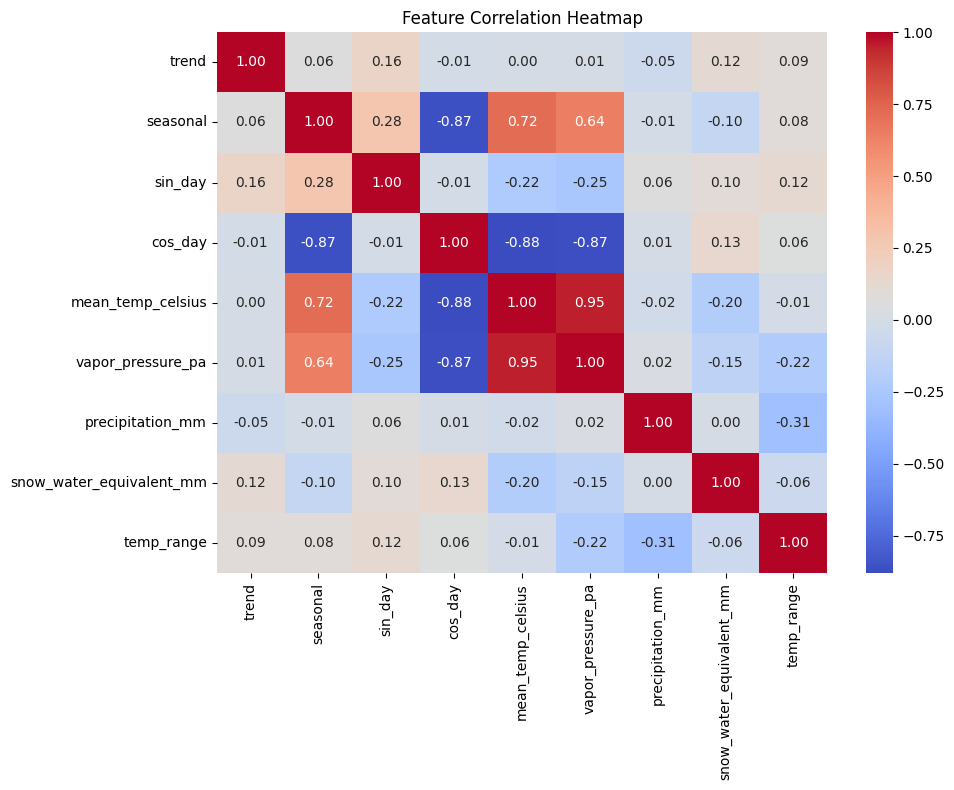

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = pd.DataFrame(X_train, columns=input_features).corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh data\feature_correlation_heatmap.png")
plt.show()

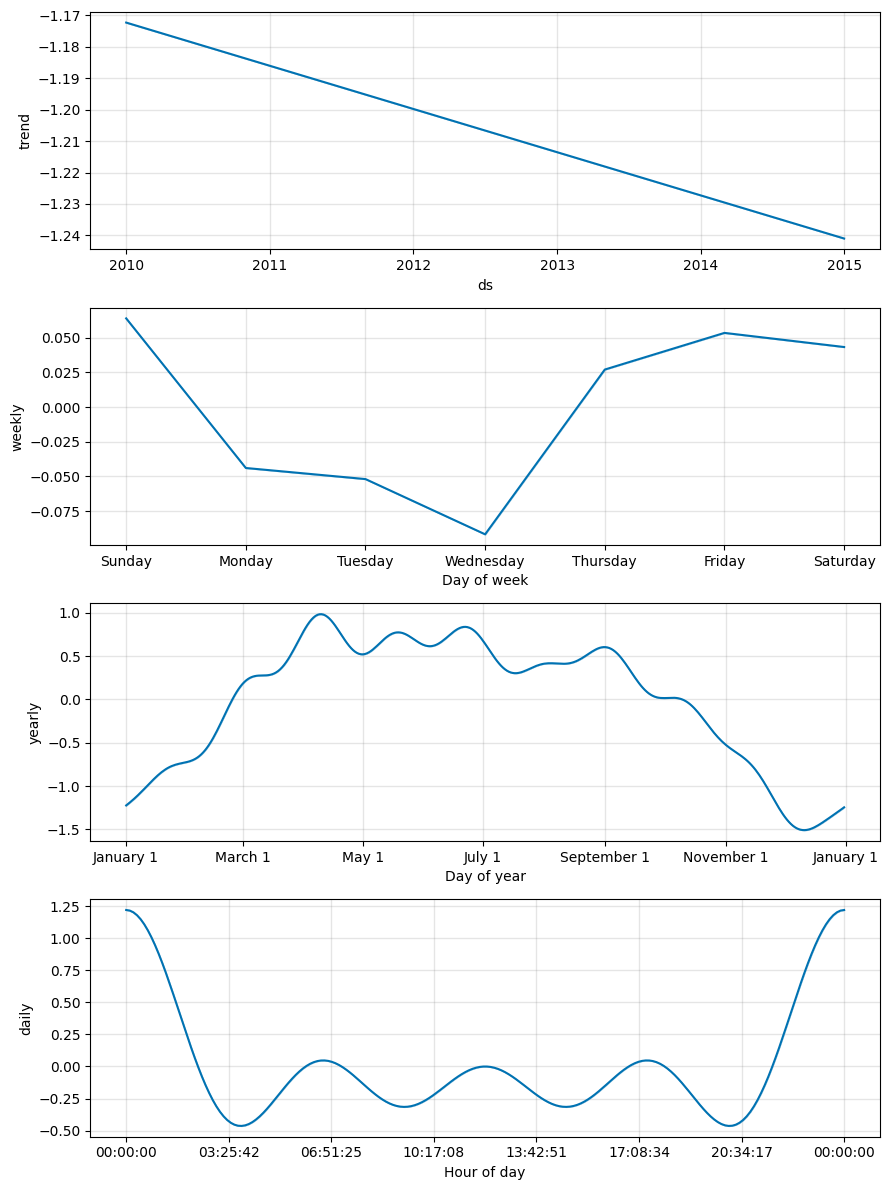

In [3]:
model.plot_components(train_forecast)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh data\Prophet_components.png")
plt.show()

In [2]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
n_qubits = 8
n_layers = 3  # Reduced for speed
theta_dim = 8
num_blocks = 3  # Reduced for speed
epochs = 70
lr = 1e-3
batch_size = 16

# Device setup using fast simulator
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define the quantum circuit
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    for layer_weights in weights:
        for i in range(n_qubits):
            qml.RY(layer_weights[i], wires=i)
        for i in range(0, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Setup QNode
weight_shapes = {"weights": (n_layers, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="adjoint")
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Define a quantum block with batched input
class QuantumBlock(nn.Module):
    def __init__(self, in_features, theta_dim):
        super().__init__()
        self.fc = nn.Linear(in_features, n_qubits)
        self.norm = nn.LayerNorm(n_qubits)
        self.q_layer = qlayer
        self.post_fc = nn.Linear(n_qubits, theta_dim)

    def forward(self, x):
        x = self.fc(x)
        x = self.norm(x)
        x_q = self.q_layer(x)  # Batched input to qlayer
        return self.post_fc(x_q)

# N-BEATS architecture with quantum blocks
class QuantumNBEATS(nn.Module):
    def __init__(self, input_dim, theta_dim, num_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([
            QuantumBlock(input_dim, theta_dim) for _ in range(num_blocks)
        ])
        self.backcast_linear = nn.Linear(theta_dim, input_dim)
        self.forecast_linear = nn.Linear(theta_dim, 1)

    def forward(self, x):
        forecast = 0
        for block in self.blocks:
            theta = block(x)
            backcast = self.backcast_linear(theta)
            forecast += self.forecast_linear(theta)
            x = x - backcast
        return forecast
    
# Prepare data
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# Initialize model, optimizer, loss
model = QuantumNBEATS(input_dim=X_train.shape[1], theta_dim=theta_dim, num_blocks=num_blocks)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

d:\Python\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
train_losses = []
test_losses = []

print("Starting training...\n")

# Training loop
best_val_loss = float('inf')  # Initialize with infinity
best_model_path = r"D:\Projects\quantum forecasting\models\best_Qmodel2.pth"  # File path to save the model

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_x, test_y = next(iter(test_loader))
        test_preds = model(test_x)
        test_loss = criterion(test_preds, test_y)

    train_losses.append(avg_train_loss)
    test_losses.append(test_loss.item())
    scheduler.step(avg_train_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {test_loss.item():.4f}")

    # Save the best model
    if test_loss.item() < best_val_loss:
        best_val_loss = test_loss.item()
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved new best model at epoch {epoch+1} with val loss {best_val_loss:.4f}")


print("\nTraining complete.")

Starting training...

Epoch 1/70 - Train Loss: 0.3990 - Test Loss: 0.1045
✅ Saved new best model at epoch 1 with val loss 0.1045
Epoch 2/70 - Train Loss: 0.0796 - Test Loss: 0.0712
✅ Saved new best model at epoch 2 with val loss 0.0712
Epoch 3/70 - Train Loss: 0.0614 - Test Loss: 0.0464
✅ Saved new best model at epoch 3 with val loss 0.0464
Epoch 4/70 - Train Loss: 0.0533 - Test Loss: 0.0408
✅ Saved new best model at epoch 4 with val loss 0.0408
Epoch 5/70 - Train Loss: 0.0473 - Test Loss: 0.0422
Epoch 6/70 - Train Loss: 0.0444 - Test Loss: 0.0361
✅ Saved new best model at epoch 6 with val loss 0.0361
Epoch 7/70 - Train Loss: 0.0427 - Test Loss: 0.0335
✅ Saved new best model at epoch 7 with val loss 0.0335
Epoch 8/70 - Train Loss: 0.0411 - Test Loss: 0.0354
Epoch 9/70 - Train Loss: 0.0397 - Test Loss: 0.0361
Epoch 10/70 - Train Loss: 0.0413 - Test Loss: 0.0285
✅ Saved new best model at epoch 10 with val loss 0.0285
Epoch 11/70 - Train Loss: 0.0382 - Test Loss: 0.0349
Epoch 12/70 - Trai

In [3]:
model = QuantumNBEATS(input_dim=X_test.shape[1], theta_dim=theta_dim, num_blocks=num_blocks)
best_model_path = r"D:\Projects\quantum forecasting\models\best_Qmodel_nbeats1.pth"
model.load_state_dict(torch.load(best_model_path))

with torch.no_grad():
    y_pred = model(X_test_t)
    test_loss = criterion(y_pred, y_test_t)
    print(f"✅ Loaded best model - Test Loss: {test_loss.item():.4f}")


C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_20356\1402447244.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


✅ Loaded best model - Test Loss: 0.0211


In [14]:
from torchinfo import summary

# Assuming batch size 32
summary(model, input_size=(16, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
QuantumNBEATS                            [16, 1]                   --
├─ModuleList: 1-7                        --                        (recursive)
│    └─QuantumBlock: 2-1                 [16, 8]                   96
│    │    └─Linear: 3-1                  [16, 8]                   80
│    │    └─LayerNorm: 3-2               [16, 8]                   16
│    └─QuantumBlock: 2-5                 --                        (recursive)
│    │    └─TorchLayer: 3-3              [16, 8]                   24
│    └─QuantumBlock: 2-3                 --                        (recursive)
│    │    └─Linear: 3-4                  [16, 8]                   72
├─Linear: 1-2                            [16, 9]                   81
├─Linear: 1-3                            [16, 1]                   9
├─ModuleList: 1-7                        --                        (recursive)
│    └─QuantumBlock: 2-4                 [16, 8]  

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure predictions and targets are NumPy arrays
y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_t.numpy().flatten()

# Compute accuracy metrics
mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 0.1096
Mean Squared Error (MSE): 0.0211
Root Mean Squared Error (RMSE): 0.1453
R² Score: 0.9784


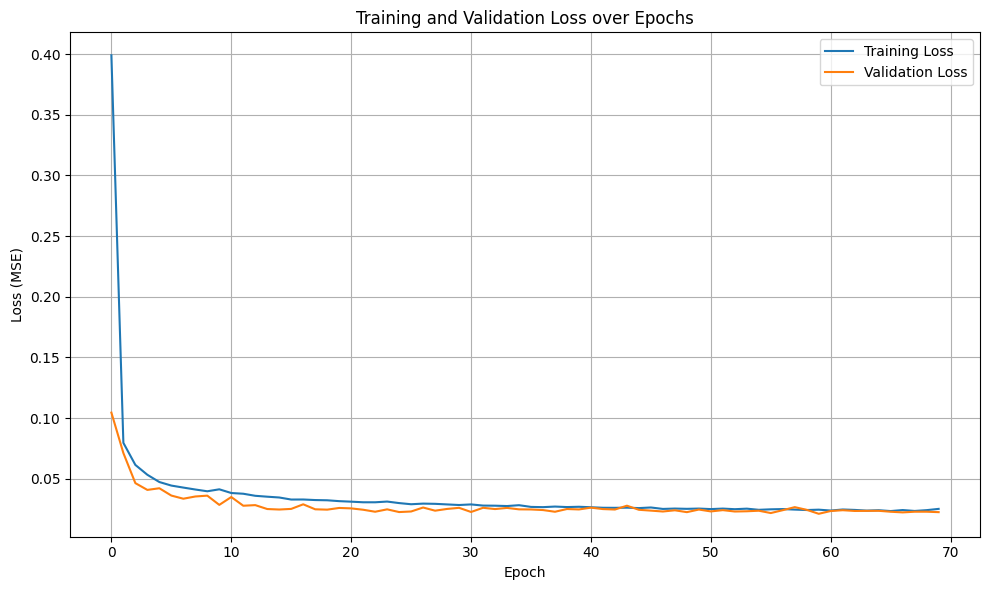

In [16]:
import matplotlib.pyplot as plt

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh data\loss_plot.png")
plt.show()

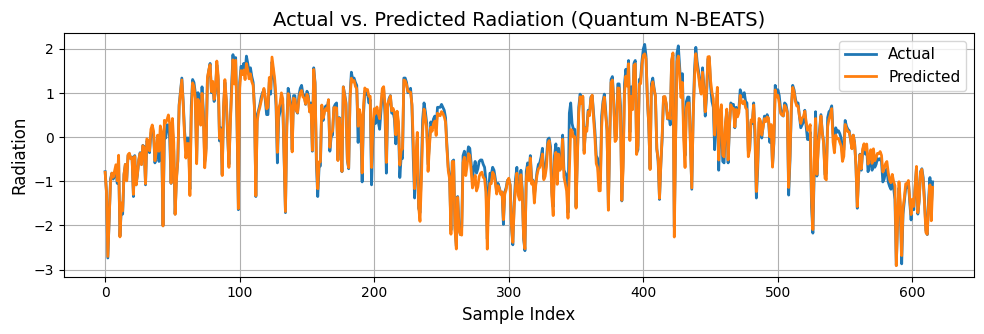

In [5]:
import matplotlib.pyplot as plt

# Set global font styles for publication quality
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

# Create plot
plt.figure(figsize=(10, 3.5))  # Ideal for one-column width (approx 3.5–3.7 in in journals)
plt.plot(y_test_np, label='Actual', linewidth=2)
plt.plot(y_pred_np, label='Predicted', linewidth=2)

plt.title("Actual vs. Predicted Radiation (Quantum N-BEATS)")
plt.xlabel("Sample Index")
plt.ylabel("Radiation")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNBEATS\actual_vs_predicted.png", dpi=300, bbox_inches='tight')

plt.show()


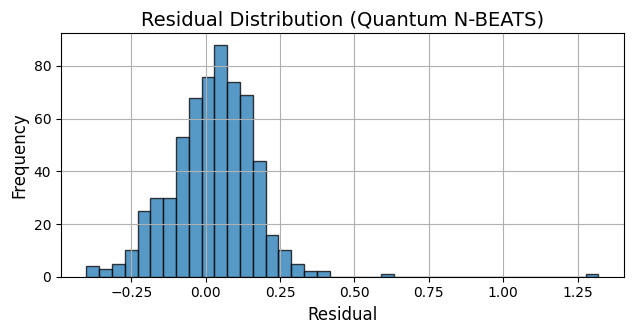

In [8]:
import matplotlib.pyplot as plt

# Set publication-style font configuration
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

residuals = y_test_np - y_pred_np

# Plot residual histogram
plt.figure(figsize=(6.5, 3.5))  # Suitable for 1-column figure (IEEE ~3.5 in width)
plt.hist(residuals, bins=40, alpha=0.75, edgecolor='black')

plt.title("Residual Distribution (Quantum N-BEATS)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()

# Save high-resolution image
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNBEATS\residual_distribution.png", dpi=300, bbox_inches='tight')

plt.show()


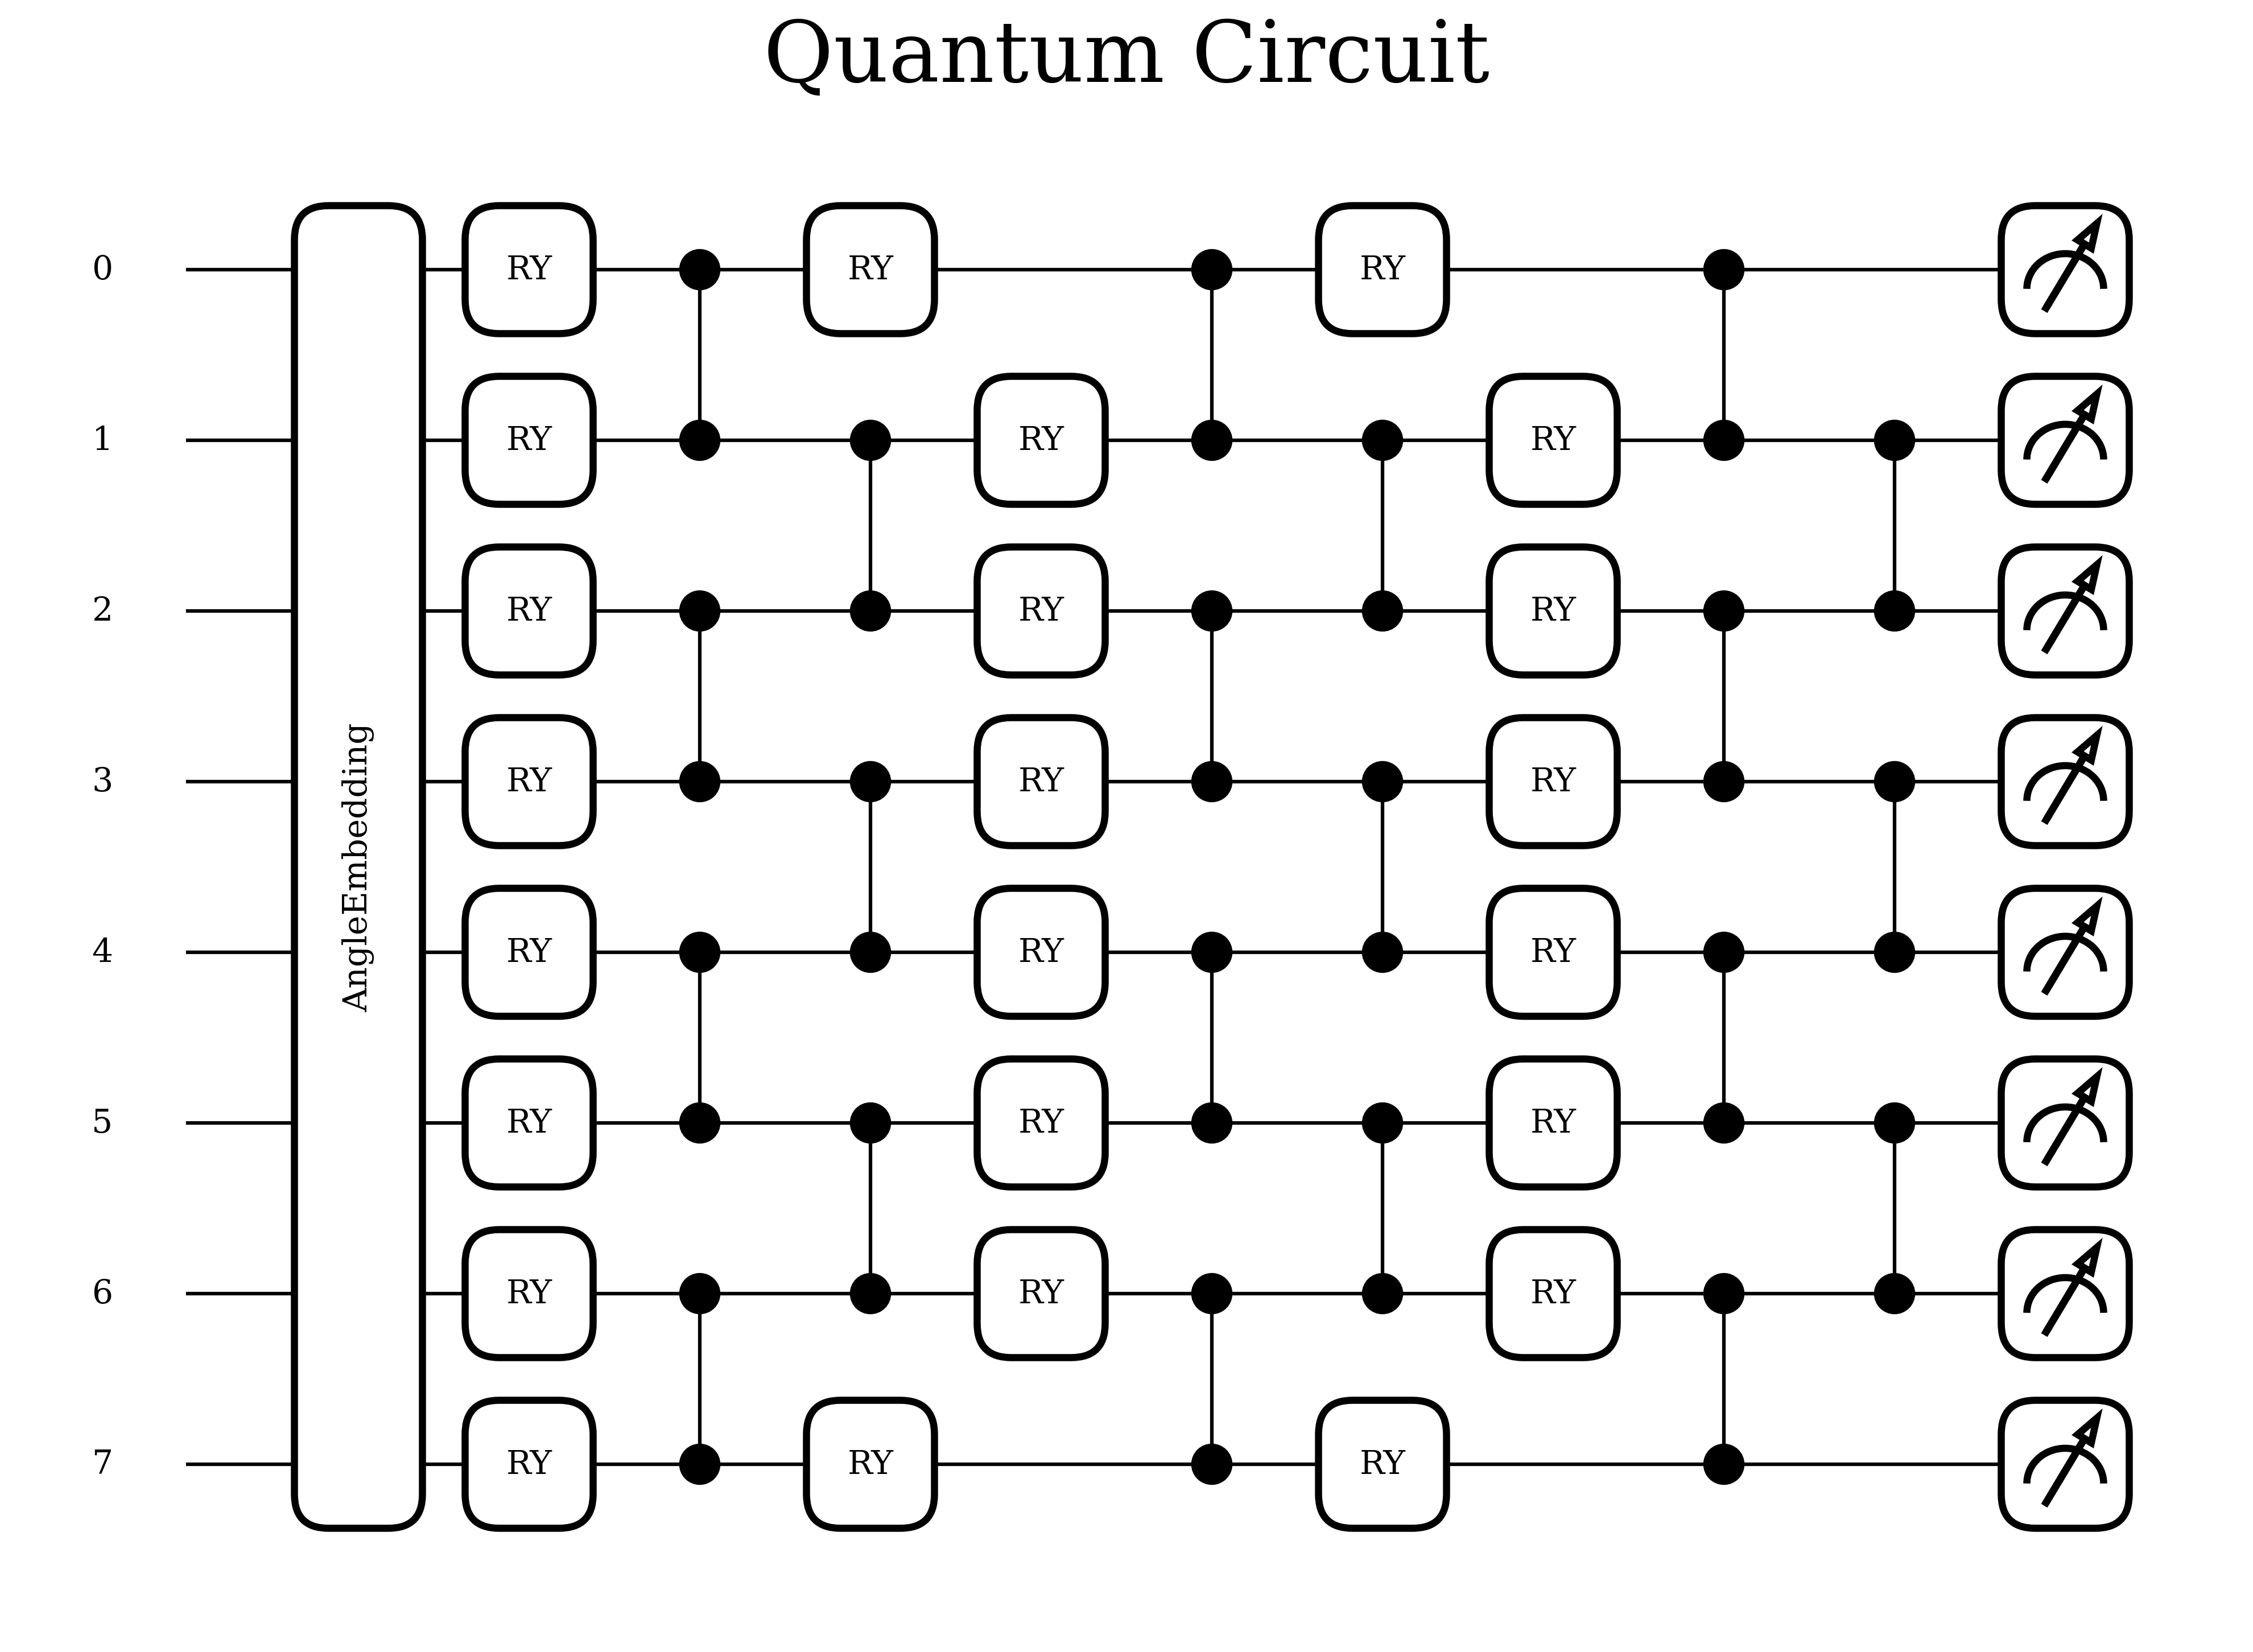

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import matplotlib.pyplot as plt

# Parameters
n_qubits = 8
n_layers = 3
theta_dim = 8
num_blocks = 3
epochs = 70
lr = 1e-3
batch_size = 16

# Setup quantum device
dev = qml.device("lightning.qubit", wires=n_qubits)

# Define the quantum circuit
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    for layer_weights in weights:
        for i in range(n_qubits):
            qml.RY(layer_weights[i], wires=i)
        for i in range(0, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define QNode and TorchLayer
weight_shapes = {"weights": (n_layers, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="adjoint")
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# Dummy data for visualization
dummy_inputs = torch.zeros(n_qubits)
dummy_weights = torch.zeros(n_layers, n_qubits)

# --- Draw circuit with matplotlib ---
fig, ax = qml.draw_mpl(qnode, style="black_white")(dummy_inputs, dummy_weights)

# Update font and layout for publication
plt.rcParams.update({
    'font.size': 10,                # IEEE-compatible font size
    'font.family': 'serif',         # IEEE and Elsevier often prefer serif fonts
    'figure.dpi': 300,
    'savefig.dpi': 600              # High DPI for vector clarity
})


# Optional PNG (high DPI)
fig.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNBEATS\quantum_circuit_ieee.png", dpi=600, bbox_inches='tight', transparent=True, facecolor='white')


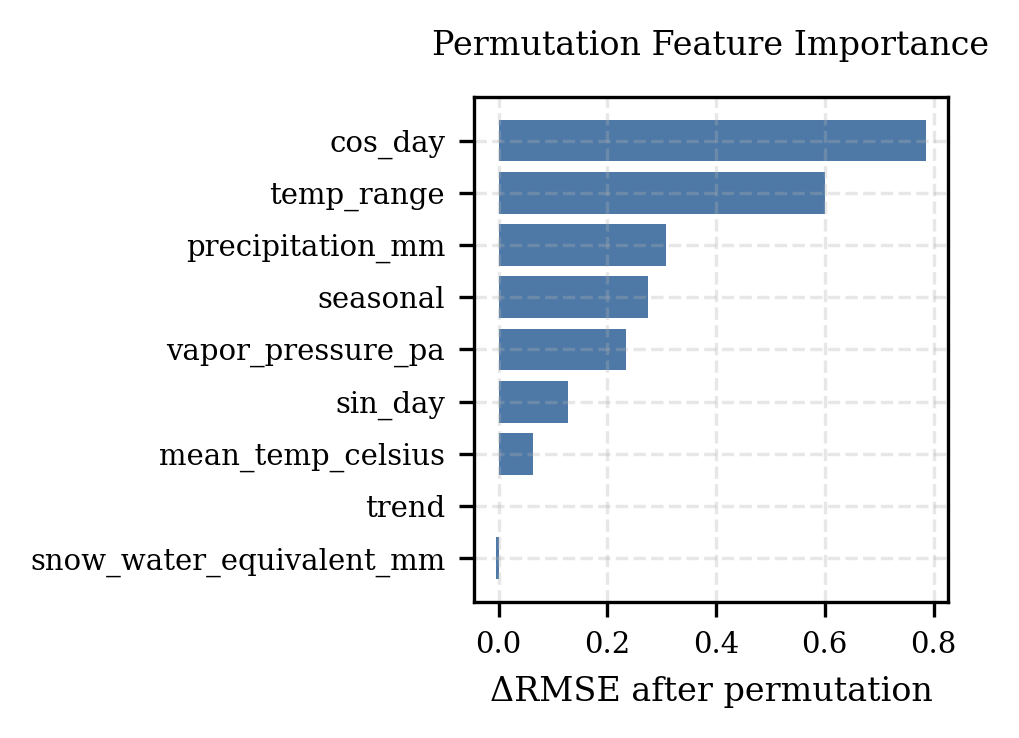

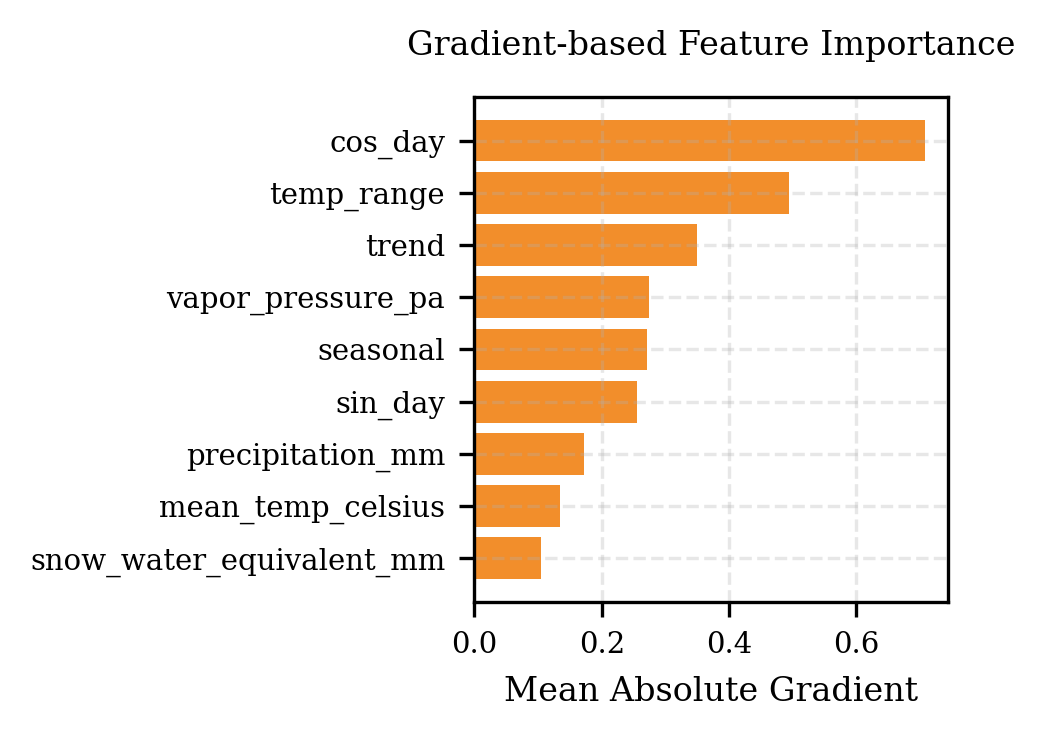

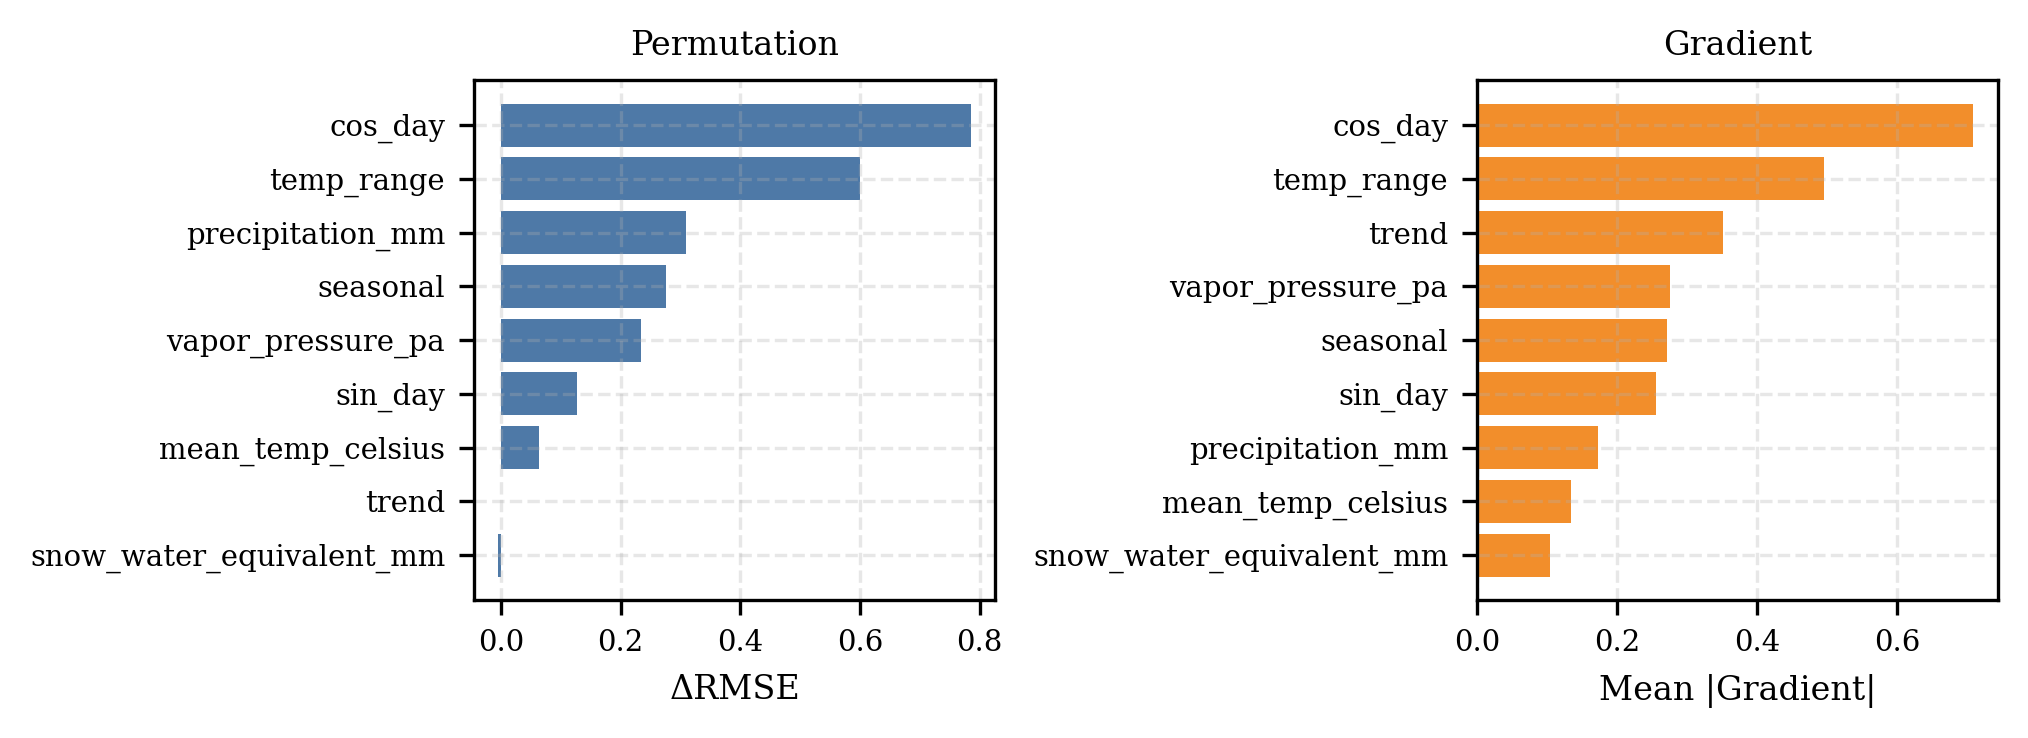

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from sklearn.metrics import mean_squared_error

# ---------- PREPARE ----------
model.eval()

# Clone data for safety
X_test_perm = X_test_t.clone()
y_test_true = y_test_t.clone()
base_preds = model(X_test_perm).detach().numpy().flatten()
base_rmse = np.sqrt(mean_squared_error(y_test_true.numpy(), base_preds))

# ---------- PERMUTATION IMPORTANCE ----------
perm_importances = []
feature_names = [
    "trend", "seasonal", "sin_day", "cos_day",
    "mean_temp_celsius", "vapor_pressure_pa", "precipitation_mm",
    "snow_water_equivalent_mm", "temp_range"
]

for i in range(X_test_perm.shape[1]):
    X_permuted = X_test_perm.clone()
    idx = torch.randperm(X_test_perm.size(0))
    X_permuted[:, i] = X_permuted[idx, i]  # Shuffle one column
    perm_preds = model(X_permuted).detach().numpy().flatten()
    perm_rmse = np.sqrt(mean_squared_error(y_test_true.numpy(), perm_preds))
    importance = perm_rmse - base_rmse
    perm_importances.append(importance)

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (RMSE Increase)": perm_importances
}).sort_values(by="Importance (RMSE Increase)", ascending=True)

# ---------- GRADIENT-BASED IMPORTANCE ----------
X_test_t.requires_grad = True
grad_importances = torch.zeros(X_test_t.shape[1])

for i in range(X_test_t.shape[0]):
    model.zero_grad()
    output = model(X_test_t[i:i+1])
    output.backward(torch.ones_like(output))
    grad_importances += X_test_t.grad[i].abs().detach()

grad_importances /= X_test_t.shape[0]
grad_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Gradient Importance": grad_importances.numpy()
}).sort_values(by="Gradient Importance", ascending=True)

# ---------- IEEE/Elsevier PLOTTING ----------
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.figsize": (3.3, 2.5),
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})

# --- Permutation Plot ---
plt.figure()
plt.barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
plt.xlabel("ΔRMSE after permutation")
plt.title("Permutation Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNBEATS\permutation_importance.png")
plt.show()

# --- Gradient Plot ---
plt.figure()
plt.barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
plt.xlabel("Mean Absolute Gradient")
plt.title("Gradient-based Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNBEATS\gradient_importance.png")
plt.show()

# --- Combined Plot (Optional) ---
fig, ax = plt.subplots(1, 2, figsize=(6.8, 2.5))
ax[0].barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
ax[0].set_title("Permutation", fontsize=8)
ax[0].set_xlabel("ΔRMSE", fontsize=8)

ax[1].barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
ax[1].set_title("Gradient", fontsize=8)
ax[1].set_xlabel("Mean |Gradient|", fontsize=8)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=7)
    a.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\QNBEATS\feature_importance_combined.png")
plt.show()
